In [1]:
import os
import sys
from collections import OrderedDict

In [2]:
sys.path.append("../..")

In [3]:
import spatialpy
spatialpy.__file__

'../../spatialpy/__init__.py'

In [4]:
import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
class Edge1(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return abs(x[0] - MAX_X_DIM) < 0.05
class Edge2(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) < 0.05
class Middle(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) >= 0.05

In [7]:
class cylinderDemo3D(spatialpy.Model):
    def __init__(self, model_name="cylinder_demo3d"):
        spatialpy.Model.__init__(self, model_name)

        self.timestep_size = 1
        
        # System constants
        D_const = 0.1

        # Define Species
        A = spatialpy.Species(name="A", diffusion_constant=D_const)
        B = spatialpy.Species(name="B", diffusion_constant=D_const)
        self.add_species([A, B])

        # Define Geometry
        self.mesh = spatialpy.Mesh.read_xml_mesh('cylinder.xml')

        # Define Subdomains
        self.set_type(Middle(), 1)
        self.set_type(Edge1(),  2)
        self.set_type(Edge2(),  3)
        
        # Restrict the movement of Chemical Species
        self.restrict(A,[1,2])
        self.restrict(B,[1,3])

        vol = self.mesh.get_vol()
        print("vol",vol)
        type = self.mesh.type
        left = numpy.sum(vol[type == 2])
        right = numpy.sum(vol[type == 3])
        print("left "+str(left)+" right "+str(right))
        
        k_react = spatialpy.Parameter(name="k_react", expression=1.0)
        k_creat1 = spatialpy.Parameter(name="k_creat1", 
                                     expression=100/left)
        k_creat2 = spatialpy.Parameter(name="k_creat2", 
                                     expression=100/right)
        self.add_parameter([k_react, k_creat1,k_creat2])


        # Define Reactions
        R1 = spatialpy.Reaction(reactants=None, products={A:1}, 
                                rate=k_creat1, restrict_to=2)
        R2 = spatialpy.Reaction(reactants=None, products={B:1}, 
                              rate=k_creat2, restrict_to=3)
        R3 = spatialpy.Reaction(reactants={A:1, B:1}, products=None, 
                              rate=k_react)
        self.add_reaction([R1, R2, R3])
        
        #self.add_initial_condition(spatialpy.ScatterInitialCondition(A,10000,[1]))


        # Define simulation timespan
        #self.set_timesteps(1, 200)
        self.timespan(range(500))

In [8]:
model = cylinderDemo3D()

vol [0.01513526 0.07034112 0.02382667 ... 0.01674217 0.02120607 0.01969156]
left 0.5092013833059308 right 0.505804729089437


In [69]:
left = numpy.sum(vol[type == 2])
right = numpy.sum(vol[type == 3])
print('left: {}, right: {}'.format(left, right))

left: 0.5092013833059308, right: 0.505804729089437


In [9]:
from spatialpy import Solver
sol = Solver(model, debug_level=2)
%time sol.compile(debug=True)
print(sol.build_dir)

Compiling Solver.  Build dir: /tmp/spatialpy_build_cou2ge_p
Creating propensity file /tmp/spatialpy_build_cou2ge_p/cylinder_demo3d_generated_model.c
cmd: cd /tmp/spatialpy_build_cou2ge_p && make -f /home/smatthe2/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/build/Makefile ROOT="/home/smatthe2/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine" ROOTINC="/home/smatthe2/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine" MODEL=/tmp/spatialpy_build_cou2ge_p/cylinder_demo3d_generated_model.c BUILD=/tmp/spatialpy_build_cou2ge_p GDB_FLAG=-g

gcc -c  -g -o main.o /tmp/spatialpy_build_cou2ge_p/cylinder_demo3d_generated_model.c -I/home/smatthe2/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -I/home/smatthe2/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/external/ -O3 -Wall -DHAVE_SSE2 -DDSFMT_MEXP=521
gcc -c  -g -o dSFMT.o /home/smatthe2/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/external/dSFMT/dSFMT.c -I/home/smatthe2/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ 

In [10]:
sol.model.listOfTypeIDs

[1, 2, 3]

In [11]:
sol.run_debugger()

Your debugger is running at http://127.0.0.1:5000


In [12]:
%time result = sol.run()

cmd: cd /tmp/spatialpy_result_6_8whfdy;/tmp/spatialpy_build_cou2ge_p/ssa_sdpd

Elapsed seconds: 10.15
*************** initialize_rdme ******************
Creating thread to process 132 particles
Creating thread to process 132 particles
Creating thread to process 132 particles
Creating thread to process 132 particles
Creating thread to process 132 particles
Creating thread to process 132 particles
Creating thread to process 132 particles
Creating thread to process 135 particles
Creating thread to update x-position index
Creating thread to create output files
[0] Starting the Sort Index threads
[WORKER 4] waiting to begin step 0
[WORKER 3] waiting to begin step 0
[WORKER 5] waiting to begin step 0
[WORKER 7] waiting to begin step 0
[WORKER 1] waiting to begin step 0
[WORKER 6] waiting to begin step 0
[SORT] begin sort
[0] Starting the Output threads
[OUT] start output_vtk__sync_step()
[SORT] sort complete took 329 us
[OUT] done output_vtk__sync_step()
[OUT] start output_vtk__async_step()


In [56]:
A_sum = numpy.sum(result.get_species("A"), axis=1)

In [66]:
for i in range(500):
    TIMEPOINT = i
    print('System total for A is: {} at {}'.format(A_sum[TIMEPOINT], TIMEPOINT))
    print('System total for B is: {} at {}'.format(B_sum[TIMEPOINT], TIMEPOINT))

System total for A is: 0.0 at 0
System total for B is: 0.0 at 0
System total for A is: 0.0 at 1
System total for B is: 3.0 at 1
System total for A is: 0.0 at 2
System total for B is: 4.0 at 2
System total for A is: 0.0 at 3
System total for B is: 5.0 at 3
System total for A is: 0.0 at 4
System total for B is: 7.0 at 4
System total for A is: 0.0 at 5
System total for B is: 10.0 at 5
System total for A is: 77309411408.0 at 6
System total for B is: 71.0 at 6
System total for A is: 98784247903.0 at 7
System total for B is: 91.0 at 7
System total for A is: 107374182507.0 at 8
System total for B is: 91.0 at 8
System total for A is: 107374182507.0 at 9
System total for B is: 91.0 at 9
System total for A is: 107374182507.0 at 10
System total for B is: 91.0 at 10
System total for A is: 107374182507.0 at 11
System total for B is: 91.0 at 11
System total for A is: 107374182507.0 at 12
System total for B is: 91.0 at 12
System total for A is: 107374182507.0 at 13
System total for B is: 92.0 at 13
S

107374182507.0
336.0
0.5092013833059308
0.505804729089437


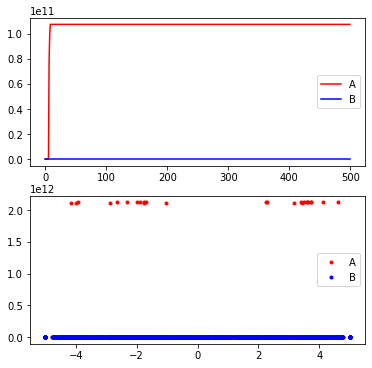

In [14]:
# Plot of the time-average spatial concentration.
x_vals = model.mesh.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=False, debug=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=False, debug=False), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.mesh.vol
type = model.mesh.type
print(numpy.sum(vol[type == 2]))
print(numpy.sum(vol[type == 3]))


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')


In [15]:
def plot_step(t_ndx,key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    plt.scatter(pts[:,0],pts[:,1],c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx))

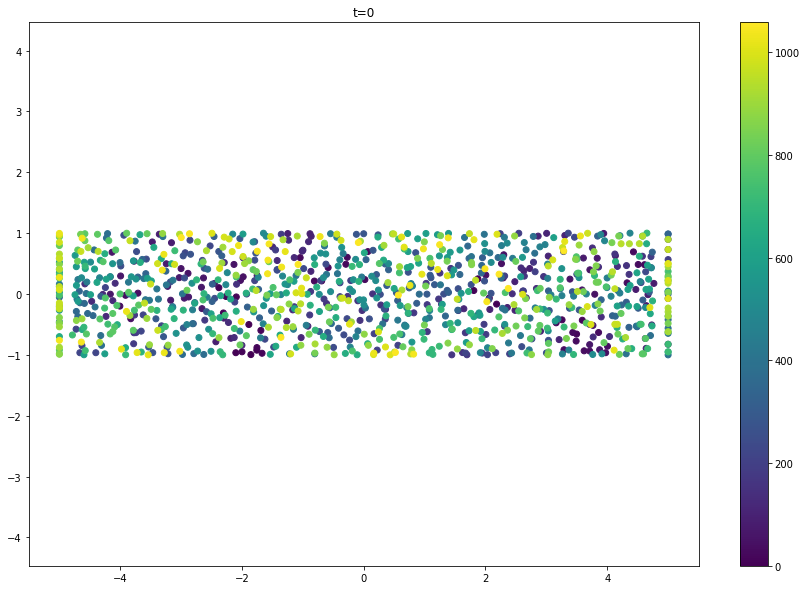

In [16]:
plot_step(0,'id')

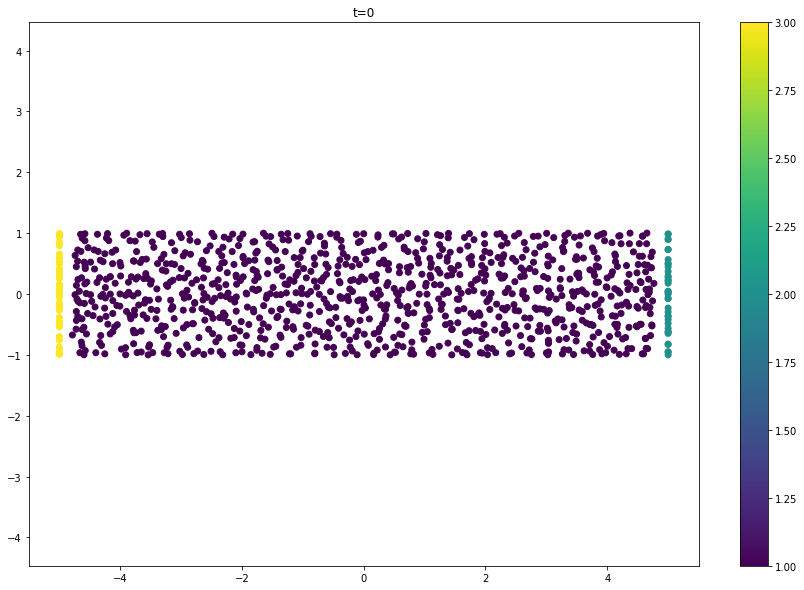

In [17]:
plot_step(0)

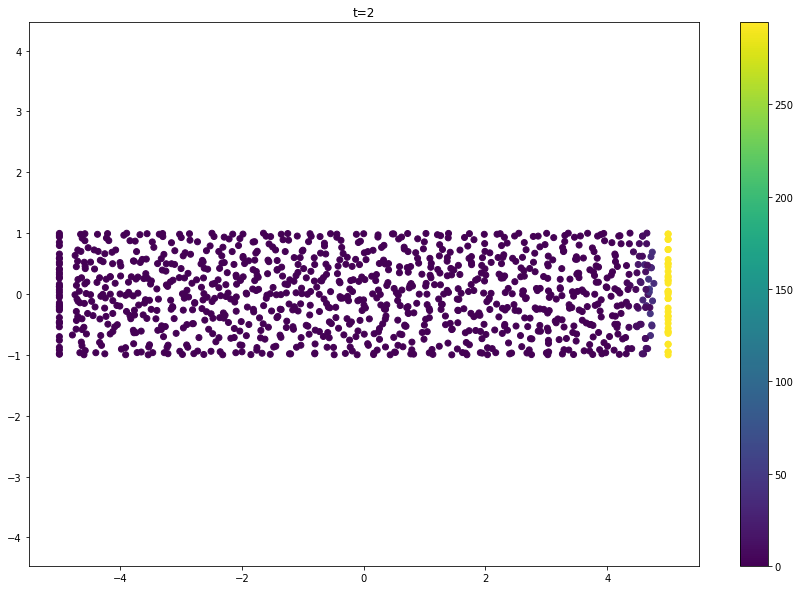

In [18]:
plot_step(2,'C[A]')

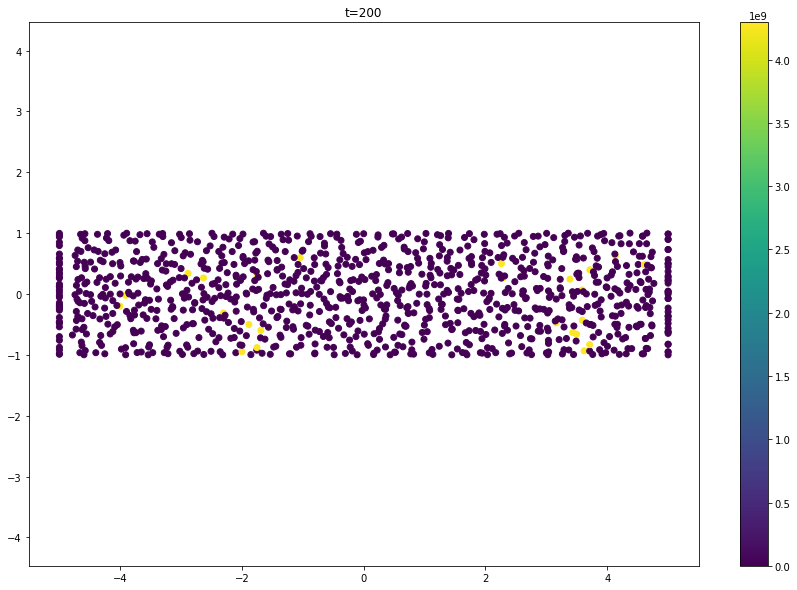

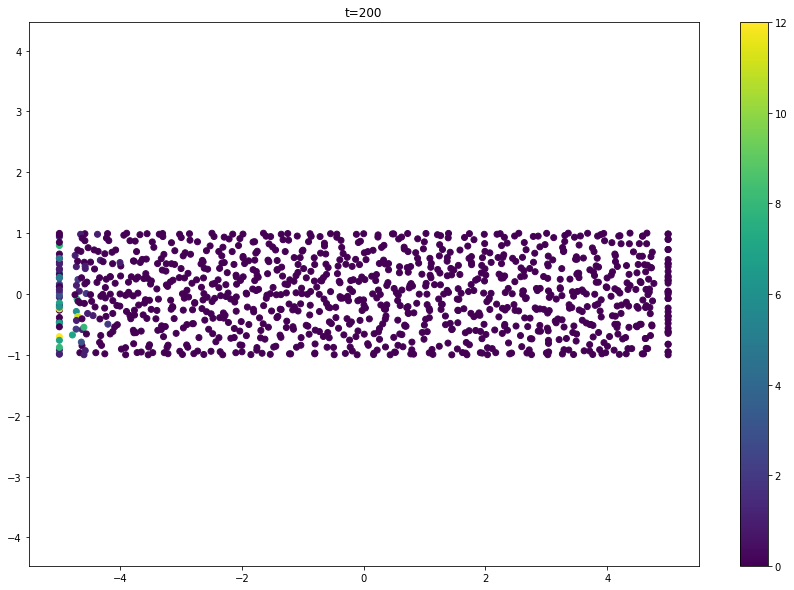

In [19]:
t=200
plot_step(t,'D[A]')
plot_step(t,'D[B]')

In [20]:
# Plot the subdomains
result.plot_property("type", 2)

In [21]:
result.plot_species("A", t_ndx=-1, deterministic=True)

In [22]:
result.plot_species("A", t_ndx=-1, size=10)

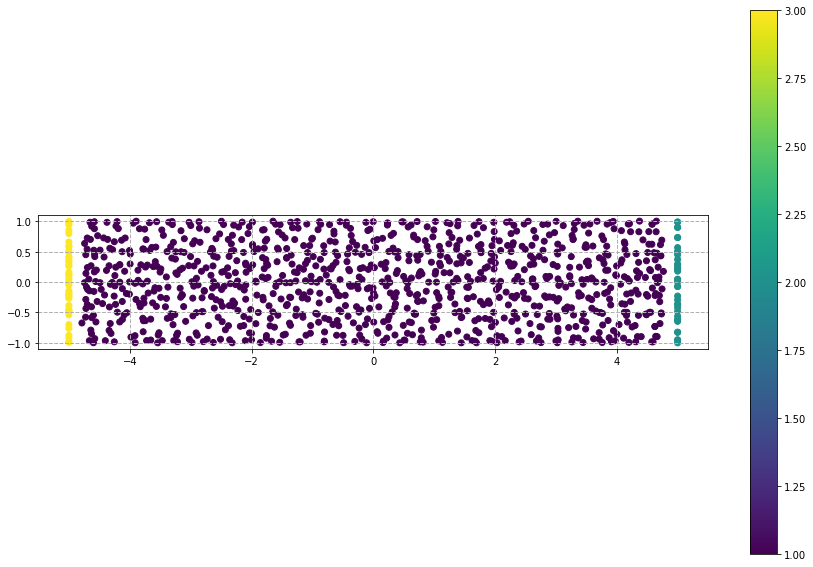

In [23]:
result.plot_property("type", use_matplotlib=True, mpl_width=15, mpl_height=10)

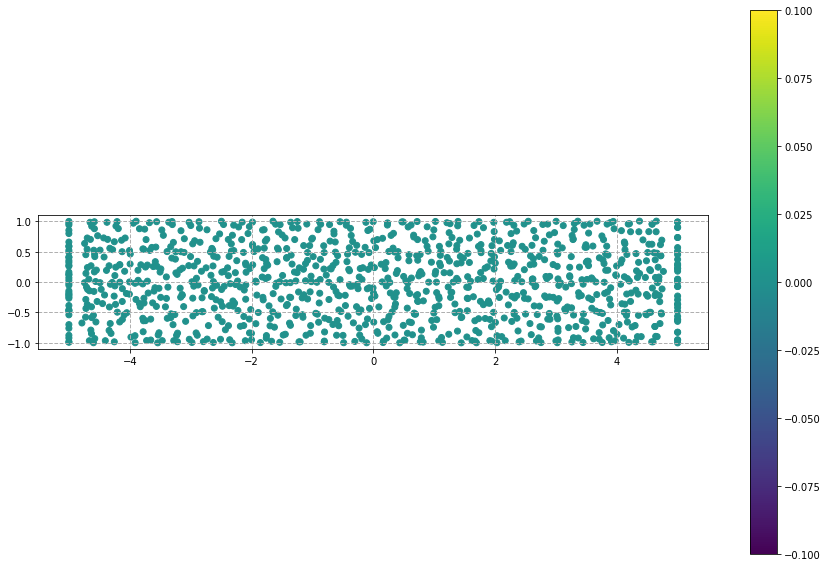

In [24]:
result.plot_species("A", deterministic=True, use_matplotlib=True, mpl_width=15, mpl_height=10)

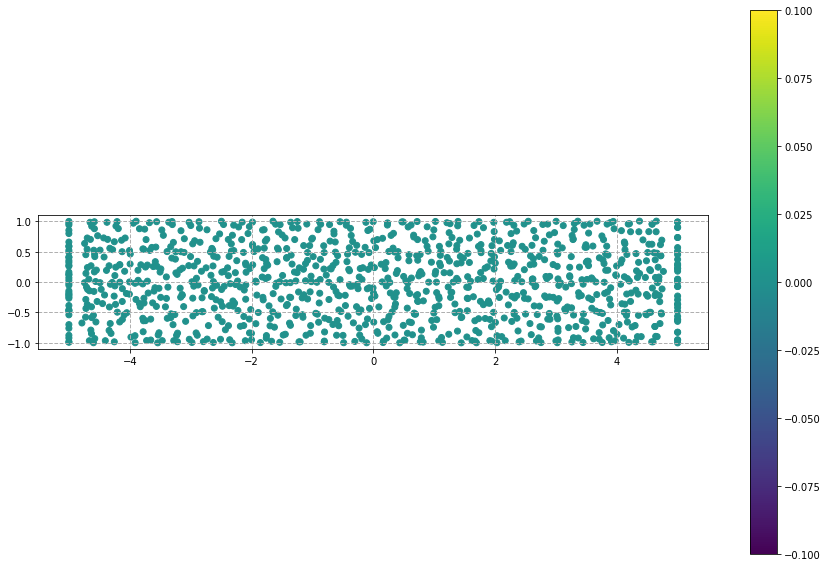

In [25]:
result.plot_species("A", use_matplotlib=True, mpl_width=15, mpl_height=10)

In [26]:
#from spatialpy.Solver import Solver
#sol = Solver(model, debug_level=2)
#%time sol.compile()


In [27]:
#sol.build_dir

In [28]:
#print(subprocess.getoutput(sol.build_dir+'/ssa_sdpd'))

In [29]:
#!/tmp/spatialpy_build_1h9cf_2u/ssa_sdpd